# Projet : A/B Testing

### Contexte:  L’A/B testing est une méthode utilisée pour comparer deux versions d'un produit ou d'un service afin de déterminer laquelle est la plus performante. Ce projet est très populaire dans le marketing, les produits digitaux et l’e-commerce pour optimiser des campagnes ou des fonctionnalités.

### Objectifs
### -Mettre en place une expérimentation contrôlée pour comparer deux groupes. 
### -Analyser les résultats avec des statistiques pour choisir la version gagnante

## Importation des bilblithèques

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import chi2_contingency

## Chargement des données

In [3]:
df = pd.read_csv("ab_data.csv")

In [4]:
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


### Vérification des valeurs manquantes

In [5]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

#### Il y'a aucune valeur manquante

### Vérification des incohérences

In [17]:
incoherences = df.query("(group  == 'control' and landing_page == 'new_page') or\
    (group  == 'treatment' and landing_page == 'old_page')")

print(incoherences)


        user_id                   timestamp      group landing_page  converted
22       767017  2017-01-12 22:58:14.991443    control     new_page          0
240      733976  2017-01-11 15:11:16.407599    control     new_page          0
308      857184  2017-01-20 07:34:59.832626  treatment     old_page          0
327      686623  2017-01-09 14:26:40.734775  treatment     old_page          0
357      856078  2017-01-12 12:29:30.354835  treatment     old_page          0
...         ...                         ...        ...          ...        ...
294014   813406  2017-01-09 06:25:33.223301  treatment     old_page          0
294200   928506  2017-01-13 21:32:10.491309    control     new_page          0
294252   892498  2017-01-22 01:11:10.463211  treatment     old_page          0
294253   886135  2017-01-06 12:49:20.509403    control     new_page          0
294331   689637  2017-01-13 11:34:28.339532    control     new_page          0

[3893 rows x 5 columns]


### Correction des incohérences

In [20]:
df_clean = df.query("(group  == 'control' and landing_page == 'old_page') or\
    (group  == 'treatment' and landing_page == 'new_page')")

print(df_clean.shape)

(290585, 5)


### Vérification des doubons

In [32]:
# Nombre total de lignes
total_lignes = df_clean.shape[0]

#Nombre d'IDs unique
ids_uniques = df_clean["user_id"].nunique()

#Nombre de doublons
doublons = total_lignes - ids_uniques
print("Nombre de doublons", doublons)

Nombre de doublons 1


#### Il y'a un seul doublon

### Suppression des doublons

In [39]:
df_clean  = df_clean.drop_duplicates("user_id",keep="first")
print(df_clean)

        user_id                   timestamp      group landing_page  converted
0        851104  2017-01-21 22:11:48.556739    control     old_page          0
1        804228  2017-01-12 08:01:45.159739    control     old_page          0
2        661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3        853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4        864975  2017-01-21 01:52:26.210827    control     old_page          1
...         ...                         ...        ...          ...        ...
294473   751197  2017-01-03 22:28:38.630509    control     old_page          0
294474   945152  2017-01-12 00:51:57.078372    control     old_page          0
294475   734608  2017-01-22 11:45:03.439544    control     old_page          0
294476   697314  2017-01-15 01:20:28.957438    control     old_page          0
294477   715931  2017-01-16 12:40:24.467417  treatment     new_page          0

[290584 rows x 5 columns]


### Repartition des groupes (pie chart)

In [41]:
#Compter les valeurs de la colonne group
counts =  df_clean["group"].value_counts()
print(counts)

group
treatment    145310
control      145274
Name: count, dtype: int64


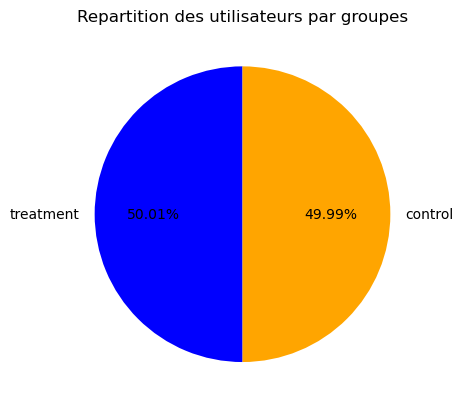

In [43]:
plt.pie(counts,
    labels=counts.index,#nom des groupes
    startangle=90,
    autopct="%.2f%%", #pour afficher les porcentages
    colors=["blue","orange"]
    
    )
plt.title("Repartition des utilisateurs par groupes")
plt.show()

### Taux de conversion (La colonne converted  = indicateur binaire (0 ou 1) qui dit si l'utilisateur a réalié l'action attendue après vu la page. Ex: s'inscire sur le site)

In [44]:
### Calcul du taux de conversion par groupe
taux_conversion = df_clean.groupby("group")["converted"].mean()
print(taux_conversion)

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64


#### 12.03% du groupe control ont réalié l'action attendue et 11.88% du groupe treatment ont réalisé l'action attendue. Le taux de converion du groupe control est légèrement plus élevé que celui du treatment

### Défintion des hypothèses

### H0: Les taux de conversion sont identiques
### H1: Les taux de conversion sont différents

### Test statistique

#### Z-test pour proportions

In [49]:
# 1 étape :  Compter les conversions et les effectifs
conv_control = df_clean.query("group  == 'control'")["converted"].sum()
n_control = df_clean.query("group  == 'control'").shape[0]

conv_treatment = df_clean.query("group  == 'treatment'")["converted"].sum()
n_treatment= df_clean.query("group  == 'treatment'").shape[0]

# 2 étape :  Proportions observées
p_control = conv_control/n_control
p_treatment = conv_treatment/n_treatment

#3 Proportion combinée sous H0
p_combined = (conv_control+conv_treatment)/(n_control + n_treatment)

#Ecart-type
SE = np.sqrt(p_combined * (1 - p_combined) * (1/n_control + 1/n_treatment))

#Statistique Z 
z_score =  (p_treatment - p_control)/SE

#p-value (bilatérale)
p_value = 2 *(1- norm.cdf(abs(z_score)))

print("Z-test pour proportions :")
print("- Z score :",z_score)
print("- p value :",p_value)
if p_value < 0.05:
    print("Différence significative")
else:
    print("Pas de différence significative")


Z-test pour proportions :
- Z score : -1.3109241984234394
- p value : 0.18988337448195103
Pas de différence significative


#### chi2

In [51]:

# Construire la table de contingence
table = pd.crosstab(df_clean["group"], df_clean["converted"])
print("Table de contingence :\n", table)

# Test du Chi²
chi2, p_value, dof, expected = chi2_contingency(table)

print("\nChi² test d'indépendance :")
print(" - Chi² :", chi2)
print(" - ddl :", dof)
print(" - p-value :", p_value)


if p_value < 0.05:
    print("Différence significative")
else:
    print("Pas de différence significative")


Table de contingence :
 converted       0      1
group                   
control    127785  17489
treatment  128046  17264

Chi² test d'indépendance :
 - Chi² : 1.7035660051885058
 - ddl : 1
 - p-value : 0.19182228096235662
Pas de différence significative


####  Les résutats des tests statistiques que nous avons effectués(z-proportion et chi2) montre que l'hypothèse H0 ne peut pas être rehetée car la -value est > à 0.05. Alors, il y'a pas différences significatives entre les deux versions de la page du site web.

### Différence de conversion entre groupes

In [54]:
# Taux de conversion par groupe
conv_rates = df_clean.groupby("group")["converted"].mean()

diff = conv_rates["treatment"] - conv_rates["control"]
print("Différence de conversion (treatment - control) :", diff)


Différence de conversion (treatment - control) : -0.0015782389853555567


### Intervalle de confiance à 95 %

In [56]:
# Variables
p_c = conv_rates["control"]
p_t = conv_rates["treatment"]
n_c = df_clean.query("group == 'control'").shape[0]
n_t = df_clean.query("group == 'treatment'").shape[0]

# Différence
diff = p_t - p_c

# Ecart-type de la différence
SE = np.sqrt(p_c*(1-p_c)/n_c + p_t*(1-p_t)/n_t)

# Intervalle de confiance
z = 1.96   # pour 95%
ci_lower = diff - z*SE
ci_upper = diff + z*SE

print("Différence :", diff)
print("Intervalle de confiance à 95% :", (ci_lower, ci_upper))


Différence : -0.0015782389853555567
Intervalle de confiance à 95% : (-0.003937903604443846, 0.0007814256337327326)


### Bar plot comparant les taux de conversion

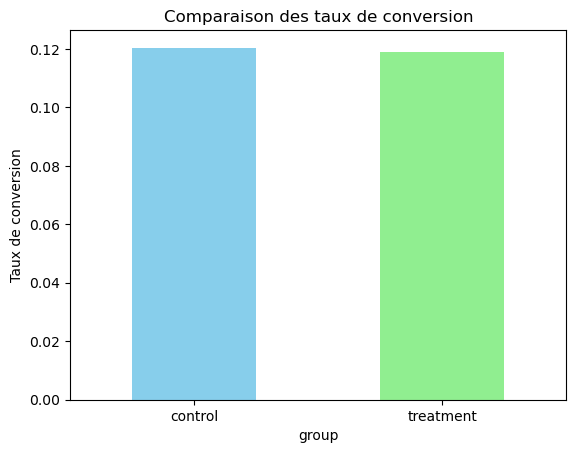

In [57]:
import matplotlib.pyplot as plt 
conv_rates.plot(kind="bar", color=["skyblue", "lightgreen"])
plt.ylabel("Taux de conversion")
plt.title("Comparaison des taux de conversion")
plt.xticks(rotation=0) 
plt.show()
 

### Courbes cumulées (conversion au fil du temps) 

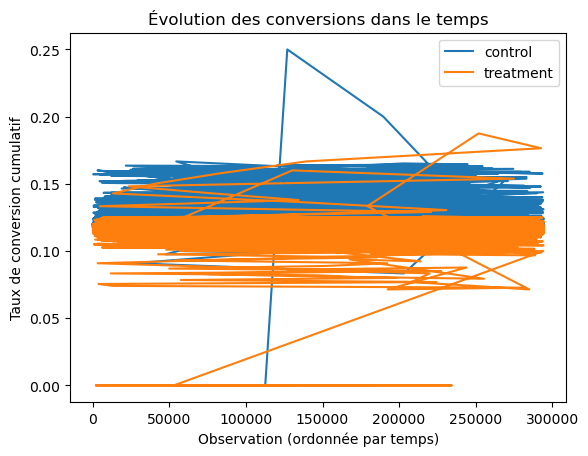

In [58]:
# Conversion cumulée par groupe dans le temps
df_clean["timestamp"] = pd.to_datetime(df_clean["timestamp"])

cumulative = (
    df_clean
    .sort_values("timestamp")
    .groupby(["group"])
    .apply(lambda x: x["converted"].expanding().mean())
    .reset_index(level=0)
)

# Tracer les courbes
for grp in cumulative["group"].unique():
    plt.plot(cumulative[cumulative["group"] == grp].index,
             cumulative[cumulative["group"] == grp]["converted"],
             label=grp)

plt.legend()
plt.xlabel("Observation (ordonnée par temps)")
plt.ylabel("Taux de conversion cumulatif")
plt.title("Évolution des conversions dans le temps")
plt.show()
